# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [2]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats
from sklearn import manifold
import random

gs.random.seed(2021)

In [3]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
rescale = True
print(f"Will save figs to {figs_dir}")

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [4]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(lines)
print(treatments)
print(f"Total number of cells : {len(cells)}")

['dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn',

The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [5]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


The size of each class is displayed below:

In [6]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [7]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [8]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 2000

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

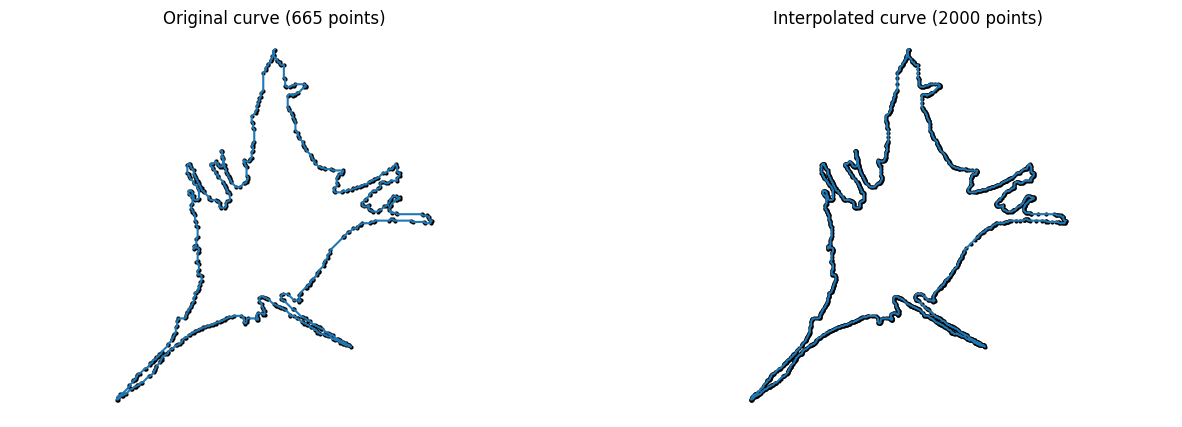

In [9]:
rand = 324
cell_rand = cells[rand]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.scatter(cell_rand[:, 0], cell_rand[:, 1], color='black', s=4)

plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.scatter(cell_interpolation[:, 0], cell_interpolation[:, 1], color='black', s=4)

plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [10]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

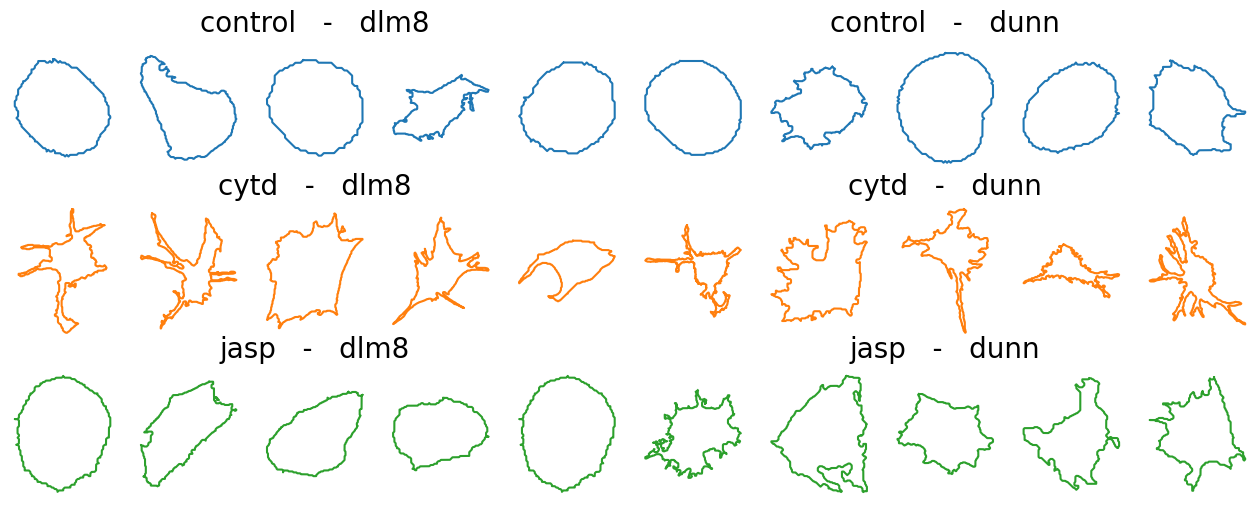

In [11]:
n_cells_to_plot = 5
# radius = 800

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            # plt.xlim(-radius, radius)
            # plt.ylim(-radius, radius)
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate sample points in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [12]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [13]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then reparameterize (only for SRV metric).

Since the alignment procedure takes 30 minutes, we ran `osteosarocoma_align.py` and saved the results in `~/dyn/datasets/osteosarcoma/aligned`

Load aligned cells from txt files. These files were generated by calling `align` function in `common.py`.

In [14]:
for treatment in TREATMENTS:
    for line in LINES:
        for metric in METRICS:
            print(f"{treatment} and {line} using {metric}: {len(ds_proc[treatment][line])}")

control and dlm8 using SRV: 114
control and dlm8 using Linear: 114
control and dunn using SRV: 204
control and dunn using Linear: 204
cytd and dlm8 using SRV: 82
cytd and dlm8 using Linear: 82
cytd and dunn using SRV: 93
cytd and dunn using Linear: 93
jasp and dlm8 using SRV: 62
jasp and dlm8 using Linear: 62
jasp and dunn using SRV: 95
jasp and dunn using Linear: 95


In [81]:

aligned_base_folder = os.path.join(data_path, dataset_name, "aligned")

ds_align = {}

for metric in METRICS:
    ds_align[metric] = {}
    if metric == 'SRV':
        aligned_folder = os.path.join(aligned_base_folder, 'projection_rescale_rotation_reparameterization')
    elif metric == 'Linear':
        aligned_folder = os.path.join(aligned_base_folder, 'projection_rescale_rotation')
    for treatment in TREATMENTS:
        ds_align[metric][treatment] = {}
        for line in LINES:
            ds_align[metric][treatment][line] = []
            cell_num = len(ds_proc[treatment][line])
            
            for i in range(cell_num):
                file_path = os.path.join(aligned_folder, f"{treatment}_{line}_{i}.txt")
                cell = np.loadtxt(file_path)
                ds_align[metric][treatment][line].append(cell)

                
            

Visualize reference cell, unaligned cell and aligned cell.

In [16]:
def generate_ellipse(n_sampling, initial_angle = 0, a=10, b = 3):
    """
    Generate points on an ellipse centered at the origin.

    Parameters:
    - initial_angle: initial angle of the start point
    - a: Semi-major axis of the ellipse.
    - b: Semi-minor axis of the ellipse.
    - n_sampling: Number of points to sample along the ellipse.

    Returns:
    - An array of shape (n_sampling, 2) where each row contains the x and y coordinates of a point on the ellipse.
    """
    # Angles at which to sample the ellipse
    theta = np.linspace(0, 2 * np.pi, n_sampling, endpoint=False)
    
    # Calculate x and y coordinates
    x = a * np.cos(theta+initial_angle)
    y = b * np.sin(theta+initial_angle)
    
    # Combine x and y coordinates into a single array
    points = np.vstack((x, y)).T
    
    return points

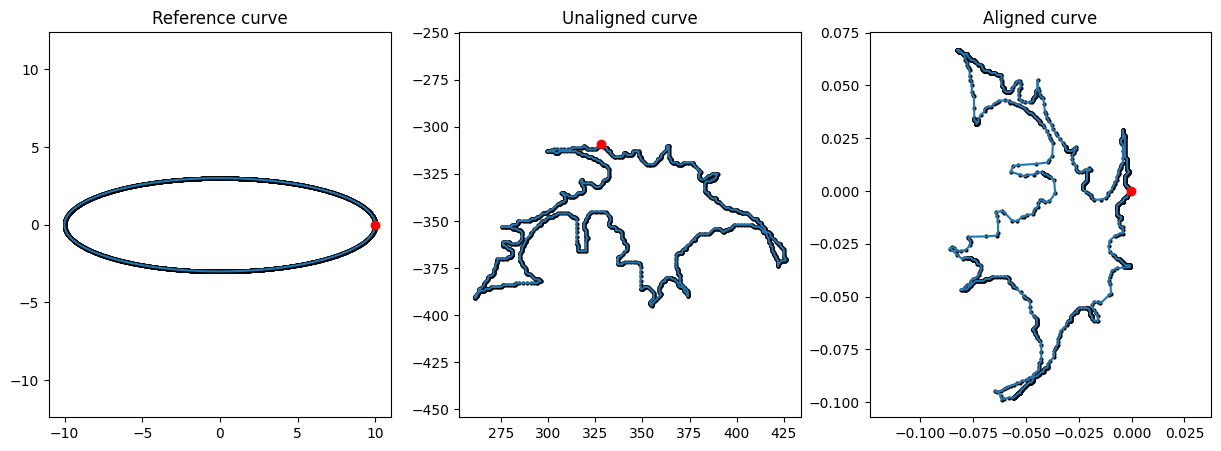

In [29]:
BASE_CURVE = generate_ellipse(k_sampling_points)
index = 10
metric = 'SRV'
unaligned_cell = ds_proc["cytd"]["dlm8"][index]
aligned_cell = ds_align[metric]["cytd"]["dlm8"][index]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot([BASE_CURVE[-1, 0], BASE_CURVE[0, 0]], [BASE_CURVE[-1, 1], BASE_CURVE[0, 1]], 'tab:blue')
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4, c='black')
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig(os.path.join(figs_dir, "alignment.svg"))
plt.savefig(os.path.join(figs_dir, "alignment.pdf"))


Examine the X shape for the cytd mean cells

(-0.2835743838747695,
 0.03711195561129201,
 -0.16149085843265518,
 0.13817466563042488)

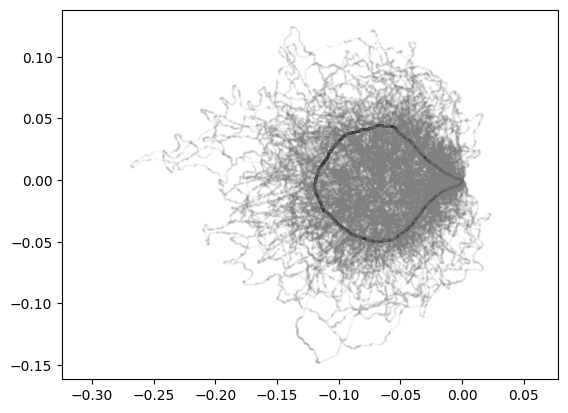

In [18]:
cells = np.array(ds_align['Linear']['cytd']['dunn'])
linear_mean = gs.mean(cells, axis=0)
plt.scatter(linear_mean[:, 0], linear_mean[:, 1], s=0.5, c='black')
for cell in cells:
    plt.scatter(cell[:, 0], cell[:, 1], s=0.5, c='grey', alpha=0.05)
plt.axis('equal')



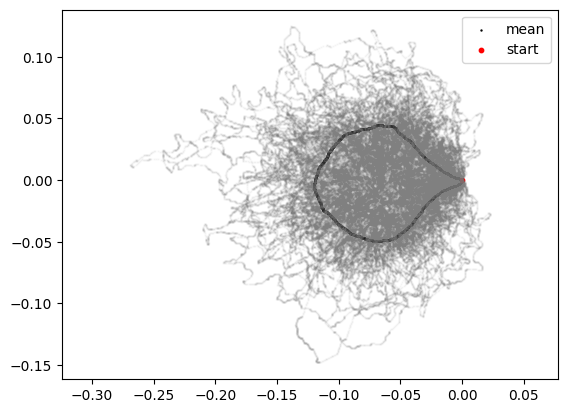

In [19]:
cells = np.array(ds_align['Linear']['cytd']['dunn'])
linear_mean = gs.mean(cells, axis=0)
plt.scatter(linear_mean[:, 0], linear_mean[:, 1], s=0.5, c='black', label='mean')
plt.scatter(linear_mean[0, 0], linear_mean[0, 1], s=10, c='red', label='start')

for cell in cells:
    plt.scatter(cell[:, 0], cell[:, 1], s=0.5, c='grey', alpha=0.05)

plt.axis('equal')
plt.legend()


We notice the mean cell has a narrower structure when approaching (0, 0). This is caused by aligning all start points of the cells to the start point of the reference ellipse (0, 0) exactly. To resolve this issue, we try postprocessing the aligned cells by aligning their barycenters to the barycenters of the ellipse, via shifting.

In [76]:
def align_barycenter(cell, ref_cell, flip):
    # print(cell[:2])
    ref_bc = np.mean(ref_cell, axis=0)
    cell_bc = np.mean(cell, axis=0)
    # print(ref_bc-cell_bc)          
    aligned_cell = cell+ref_bc-cell_bc
    # print(aligned_cell[:2])
    if flip:
        aligned_cell[:, 0] = 2*ref_bc[0]-aligned_cell[:, 0]
        # Swap the points
        med_index = int(np.floor(aligned_cell.shape[0]/2))
        flipped_aligned_cell = np.concatenate((aligned_cell[med_index:], aligned_cell[:med_index]), axis=0)
        flipped_aligned_cell = np.flipud(flipped_aligned_cell)
        aligned_cell = flipped_aligned_cell
    return aligned_cell


In [86]:
ds_align['SRV']['cytd']['dunn'][0].shape

(1999, 2)

(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)
(1999, 2) (2000, 2)


(-0.34324068205769503,
 0.18194693591811367,
 -0.1468132957965148,
 0.17366598346873263)

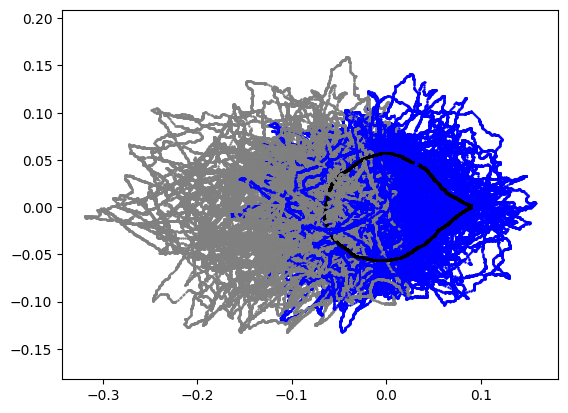

In [91]:
cells = np.array(ds_align['Linear']['cytd']['dlm8'][:])

aligned_cells = []
for cell in cells:
    print(cell.shape, BASE_CURVE.shape)
    flip = False
    aligned_cells.append(align_barycenter(cell, BASE_CURVE, flip))
aligned_cells = np.array(aligned_cells)

linear_mean = gs.mean(aligned_cells, axis=0)
for cell, aligned_cell in zip(cells, aligned_cells):
    plt.scatter(linear_mean[:, 0], linear_mean[:, 1], s=0.5, c='black')
    plt.scatter(cell[:, 0], cell[:, 1], s=0.5, c='grey')
    plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=0.5, c='blue')



plt.axis('equal')


This still does not work since shifting the cell still leads to the left side having narrow structure. We trying aligning the cells by the barycenters and random flip.

False
False
False
True
True
False
True
True
True
True
True
True
False
False
True
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
True
False
False
False
True
True
True
True
True
False
False
False
False
True
False
False
True
False
True
False
False
True
False
False
True
False
False
True
True
False
False
True
False
True
False
True
False
True
False
True
False
False
False
True
True
True
False
False
False
True
True
True


(-0.17039528750449526,
 0.18175924019594283,
 -0.1455564687255391,
 0.15511823047443835)

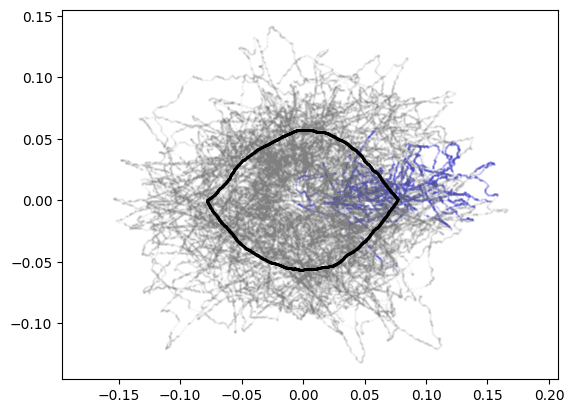

In [90]:

aligned_cells = []
for cell in cells:
    flip = random.choice([True, False])
    print(flip)
    aligned_cell = align_barycenter(cell, BASE_CURVE, flip)
    aligned_cells.append(aligned_cell)
    plt.scatter(aligned_cell[:100, 0], aligned_cell[:100, 1], s=0.5, c='blue', alpha=0.1)

aligned_cells = np.array(aligned_cells)

for cell in aligned_cells:
    plt.scatter(cell[:, 0], cell[:, 1], s=0.5, c='grey', alpha=0.05)

linear_mean = gs.mean(aligned_cells, axis=0)
plt.scatter(linear_mean[:, 0], linear_mean[:, 1], s=0.5, c='black')
plt.axis('equal')


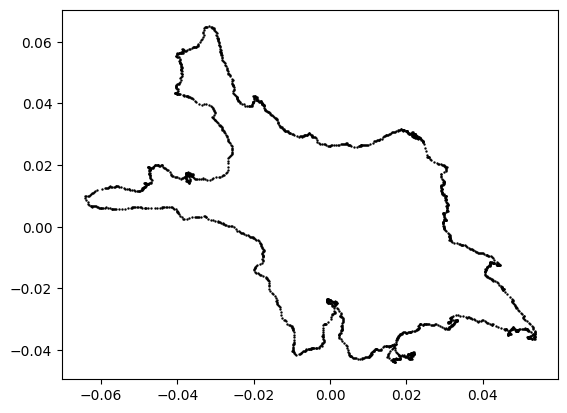

In [50]:
plt.scatter(linear_mean[:, 0], linear_mean[:, 1], s=0.5, c='black')


Flip the cells does not work. We try aligning cells to the reference ellipse with different start points

In [30]:
rescale = True
rotation = True
reparameterization = False

BASE_CURVE = generate_ellipse(k_sampling_points)
unaligned_cell = ds_proc["cytd"]["dlm8"][index]
ref_cell, aligned_cell = align(unaligned_cell, BASE_CURVE, rescale, rotation, reparameterization, k_sampling_points)



Text(0.5, 1.0, 'Aligned curve')

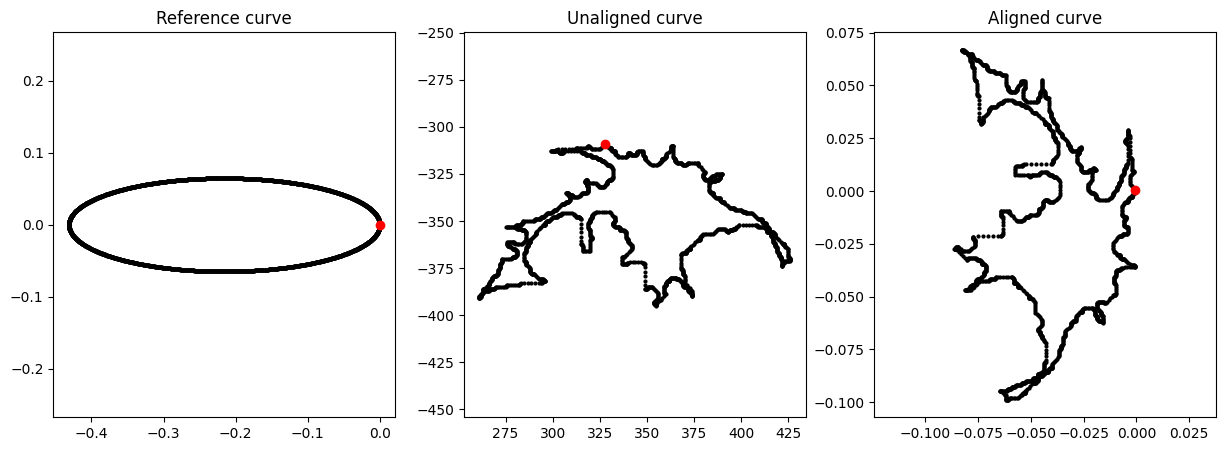

In [31]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.scatter(ref_cell[:, 0], ref_cell[:, 1], s=4, c='black')
plt.scatter(ref_cell[0, 0], ref_cell[0, 1], c="red")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.scatter(unaligned_cell[0, 0], unaligned_cell[0, 1], c='red')
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.scatter(aligned_cell[0, 0], aligned_cell[0, 1], c='red')
plt.axis("equal")
plt.title("Aligned curve")


In [35]:
def rotation_align(curve, base_curve, k_sampling_points):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)

    # Rotation is done after projection, so the origin is removed
    total_space = DiscreteCurvesStartingAtOrigin(k_sampling_points=k_sampling_points-1)
    total_space.fiber_bundle = SRVRotationBundle(total_space)

    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = total_space.fiber_bundle.align(
            point=gs.array(reparametrized), base_point=base_curve
        )
        distances[shift] = np.linalg.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    print("shift_min is:", shift_min)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = total_space.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve



def new_align(point, base_point, rescale, rotation, reparameterization, k_sampling_points):
    """
    Align point and base_point via quotienting out translation, rescaling and reparameterization

    Right now we do not quotient out rotation since
    - Current geomstats does not support changing aligner for SRVRotationReparametrizationBundle
    - The base curve we chose is a unit circle, so quotienting out rotation won't affect the result too much
    """

    total_space = DiscreteCurvesStartingAtOrigin(k_sampling_points=k_sampling_points)
   
    
    # Quotient out translation
    point = total_space.projection(point)
    base_point = total_space.projection(base_point)

    # Quotient out rescaling
    if rescale:
        point = total_space.normalize(point)
        base_point = total_space.normalize(base_point)
    
    # Quotient out rotation
    if rotation:
        point = rotation_align(point, base_point, k_sampling_points)

    # Quotient out reparameterization
    if reparameterization:
        aligner = DynamicProgrammingAligner(total_space)
        total_space.fiber_bundle = SRVReparametrizationBundle(total_space, aligner=aligner)
        point = total_space.fiber_bundle.align(point, base_point)
    return point

In [38]:
BASE_CURVE = generate_ellipse(k_sampling_points)
unaligned_cell = ds_proc["cytd"]["dlm8"][1]
aligned_cell = new_align(unaligned_cell, BASE_CURVE, rescale, rotation, reparameterization, k_sampling_points)

shift_min is: 9


Text(0.5, 1.0, 'Aligned curve')

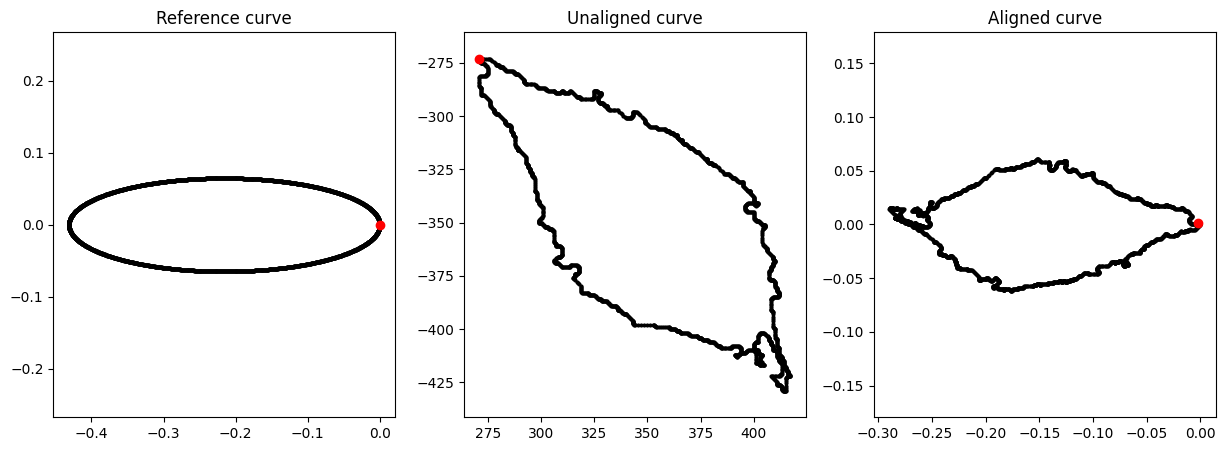

In [39]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.scatter(ref_cell[:, 0], ref_cell[:, 1], s=4, c='black')
plt.scatter(ref_cell[0, 0], ref_cell[0, 1], c="red")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.scatter(unaligned_cell[0, 0], unaligned_cell[0, 1], c='red')
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.scatter(aligned_cell[0, 0], aligned_cell[0, 1], c='red')
plt.axis("equal")
plt.title("Aligned curve")


In [28]:
aligned_cells = []
for cell in cells:
    aligned_cell = align(cell, BASE_CURVE, rescale, rotation, reparameterization, k_sampling_points)
    aligned_cells.append(aligned_cell)
    plt.figure()
    plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1])
    plt.axis('equal')
    

TypeError: tuple indices must be integers or slices, not tuple

<Figure size 640x480 with 0 Axes>

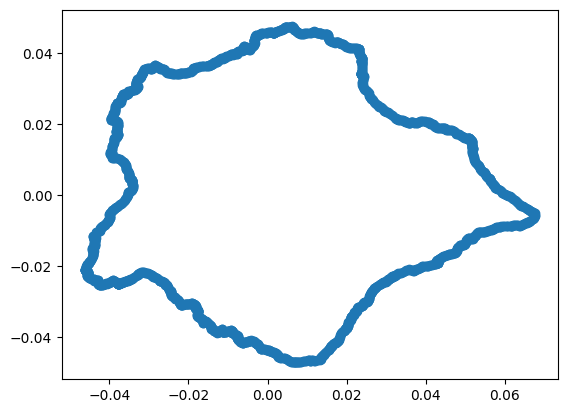

In [ ]:
linear_mean = gs.mean(aligned_cells, axis=0)
plt.scatter(linear_mean[:, 0], linear_mean[:, 1])
